In [ ]:
"""
Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

In [ ]:
### Introduction

The dataset used in SAP Credit Card Fraud Prediction blog post is adataset published by Kaggle in 2016-11-03 https://www.kaggle.com/mlg-ulb/creditcardfraud . The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 


The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.



### Upgrade Sagemaker and Import the required Python libraries.

In [1]:
!pip install --upgrade sagemaker
!pip install boto3 --upgrade

Requirement already up-to-date: sagemaker in /opt/conda/lib/python3.7/site-packages (2.23.0)
Requirement already up-to-date: boto3 in /opt/conda/lib/python3.7/site-packages (1.16.44)


In [2]:
import os
import boto3
import re
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
import sagemaker.amazon.amazon_estimator
import seaborn as sns

role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()



### Data Engineering
Before we start  training the fraud detection model you need to prepare the dataset to be ready for the training stage.This process could include many steps like data cleansing, normalisation, encoding and even engineer new data features. And usually the data scientist can spend up to 80% of their time in data preparation tasks rather than actually machine learning work.Most of the data transformation already done by AWS Glue Databrew in the previous section,so let's load the dataset to explore it and see what else we can do.

Start by loading the data from S3 to datafram in sagemaker.

In [3]:
Bucket_name=<Add your S3 bucket name> ####update your s3 bucket name
Prefix_name='transformed _dataset/'
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=Bucket_name, Prefix=Prefix_name)['Contents']
contents =contents[1:]
dfs = []
for f in contents:
    file_part_name=(f['Key'])
    file_part_name_full_name= Bucket_name + "/"+file_part_name
    file_part_name_full_name = "s3://"+file_part_name_full_name
    #print(file_part_name_full_name) 
    dfs.append(pd.read_csv(file_part_name_full_name))
dataframe = pd.concat(dfs, axis=0, ignore_index=True)


dataframe.head()

,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,v16,...,v27,v28,v3,v4,v5,v6,v7,v8,v9,class
0,6.477130,0.701062,-1.205952,-0.084036,0.580124,0.470178,0.081142,-0.327771,-1.327925,1.218929,...,-0.288845,0.252147,-2.013455,0.597907,-2.878689,0.991717,0.793342,-0.149117,0.241714,0.0
1,-0.071724,0.702305,-1.493401,-0.378103,-0.547924,0.177054,-0.410391,-0.185396,-0.324477,-0.938389,...,0.365494,0.044894,0.382062,0.142090,2.758508,4.479971,0.062068,1.188688,-0.014246,0.0
2,2.513914,0.703021,-1.621709,-1.291223,0.343289,0.402989,-0.401115,0.176922,-1.095927,-0.042943,...,0.175126,0.055355,-0.237813,-0.641470,-1.733949,1.122214,3.477529,-0.452957,-0.169406,0.0
3,2.424677,0.703294,0.933715,0.801436,0.914612,-0.397240,-0.863505,0.943349,-0.979870,0.339959,...,-0.235229,0.020795,-3.303049,-0.500581,-0.294585,-0.915057,1.185340,-0.589403,-1.290019,0.0
4,2.505358,0.706790,0.574843,-0.269148,0.635920,0.865186,-0.451661,0.599196,-0.236059,-0.757037,...,-0.175846,0.032754,-2.478355,0.463651,0.312697,1.715847,0.632856,0.228173,0.517147,0.0


In [4]:
#Print total number of rows to confirm that all dataset loaded successfully 
print("Total number of rows is :- " + str(dataframe.time_normalized.count()))



Total number of rows is :- 284807


In [5]:
#Get The Dataframe Summary
dataframe.describe()

,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,v16,...,v27,v28,v3,v4,v5,v6,v7,v8,v9,class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-1.705932e-14,2.061596e-16,1.758914e-12,7.091510e-13,1.875145e-12,1.052936e-12,7.128125e-13,-1.469801e-13,-5.232181e-13,-2.291081e-13,...,3.331878e-12,-3.518893e-12,-9.659102e-13,8.304633e-13,1.645166e-13,4.248481e-13,-3.046747e-13,8.758295e-14,-1.178613e-12,0.001727
std,1.000000e+00,1.000000e+00,1.958696e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,...,4.036325e-01,3.300833e-01,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,0.041527
min,-3.532288e-01,-1.996580e+00,-5.640751e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,...,-2.256568e+01,-1.543008e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,0.000000
25%,-3.308395e-01,-8.552105e-01,-9.203734e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,...,-7.083953e-02,-5.295979e-02,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,0.000000
50%,-2.652710e-01,-2.131450e-01,1.810880e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,...,1.342146e-03,1.124383e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,0.000000
75%,-4.471699e-02,9.372158e-01,1.315642e+00,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,...,9.104512e-02,7.827995e-02,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,0.000000
max,1.023621e+02,1.642055e+00,2.454930e+00,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,...,3.161220e+01,3.384781e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,1.000000


In [6]:
dataframe.head()

,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,v16,...,v27,v28,v3,v4,v5,v6,v7,v8,v9,class
0,6.477130,0.701062,-1.205952,-0.084036,0.580124,0.470178,0.081142,-0.327771,-1.327925,1.218929,...,-0.288845,0.252147,-2.013455,0.597907,-2.878689,0.991717,0.793342,-0.149117,0.241714,0.0
1,-0.071724,0.702305,-1.493401,-0.378103,-0.547924,0.177054,-0.410391,-0.185396,-0.324477,-0.938389,...,0.365494,0.044894,0.382062,0.142090,2.758508,4.479971,0.062068,1.188688,-0.014246,0.0
2,2.513914,0.703021,-1.621709,-1.291223,0.343289,0.402989,-0.401115,0.176922,-1.095927,-0.042943,...,0.175126,0.055355,-0.237813,-0.641470,-1.733949,1.122214,3.477529,-0.452957,-0.169406,0.0
3,2.424677,0.703294,0.933715,0.801436,0.914612,-0.397240,-0.863505,0.943349,-0.979870,0.339959,...,-0.235229,0.020795,-3.303049,-0.500581,-0.294585,-0.915057,1.185340,-0.589403,-1.290019,0.0
4,2.505358,0.706790,0.574843,-0.269148,0.635920,0.865186,-0.451661,0.599196,-0.236059,-0.757037,...,-0.175846,0.032754,-2.478355,0.463651,0.312697,1.715847,0.632856,0.228173,0.517147,0.0


Before start the data engineering we will start by keeping %10 of the data a side to evualte the model at the end

In [7]:
#A good practise that you shuffle the dataset before splitting it.
dataframe_shuffled_v1 = dataframe.sample(frac=1)
dataframe_shuffled_v1.head()

,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,v16,...,v27,v28,v3,v4,v5,v6,v7,v8,v9,class
181348,-0.349670,1.331704,0.018342,-0.216823,0.347653,0.174022,-1.082523,0.505844,-0.916061,0.189681,...,0.239945,0.080909,0.156352,-0.776671,0.567949,-0.557120,0.807725,0.047489,-0.121446,0.0
73405,-0.235405,-0.138179,1.881683,1.515059,-0.760622,-0.183061,0.219874,0.388546,-0.268406,0.778955,...,-0.050844,-0.037608,-0.835545,3.700960,0.560205,-0.173931,0.323333,-0.152078,-1.201818,0.0
261081,-0.349231,1.070059,2.118761,0.165528,0.097800,0.825381,0.635507,0.516102,0.114355,0.300804,...,-0.026789,-0.071847,-1.893159,-0.118184,0.847332,0.002883,0.104505,-0.119446,0.331013,0.0
18669,-0.022748,-0.317803,0.941004,-0.465619,-1.016916,1.263393,0.268909,-0.830335,-1.752041,-1.161679,...,0.081119,0.042423,1.154240,1.775322,-0.731369,0.638556,-0.402643,0.236255,1.163687,0.0
72947,-0.247120,-1.340268,0.019950,0.639365,-0.421279,-0.616339,-0.075733,0.127544,0.425808,0.852212,...,-0.074799,-0.126719,-0.096844,0.756868,2.913522,3.771792,0.399891,0.707786,-1.145086,0.0


In [8]:
frame, test_dataset = np.split(dataframe_shuffled_v1, [int(0.9 * len(dataframe_shuffled_v1))])

In [9]:
print("Total number of rows is in frame_dataset :- " + str(frame.time_normalized.count()))
print("Total number of rows is in test_dataset :- " + str(test_dataset.time_normalized.count()))

Total number of rows is in frame_dataset :- 256326
Total number of rows is in test_dataset :- 28481


Most of the data engineering part we already done with AWS Glue DataBrew as mentioned before. However, the dataset has huge unbalance between fraud and unfraud label which can impact the model. Let's plot that out as below.

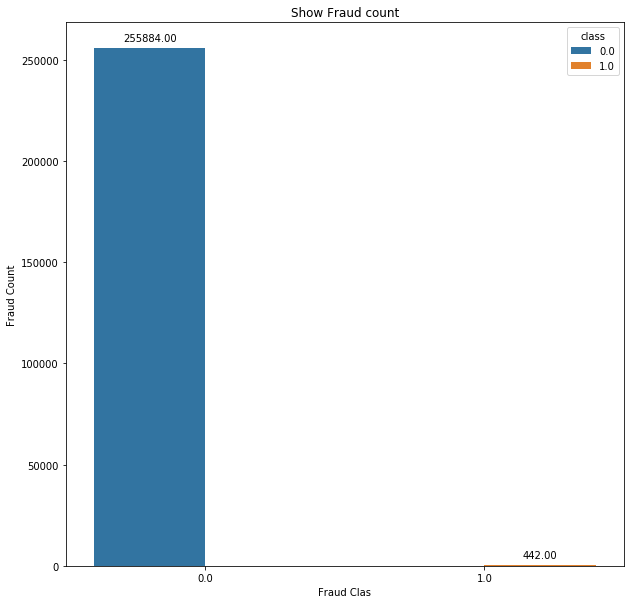

In [10]:

plt.figure(figsize=(10, 10))
splot = sns.countplot('class', data=frame, hue="class")
plt.title('Show Fraud count')
plt.xlabel('Fraud Clas')
plt.ylabel('Fraud Count')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


### Fix Datset unbalance

To solve the unbalance problem you can either over-sample or under-sample your dataset. In this notebook we will implement over-sampling. There are 3 main over-sampling techniques. 
1- Naive random over-sampling :- generate new samples by randomly sampling with replacement the current available samples.
2-Synthetic Minority Oversampling Technique (SMOTE):- It generate synthetic samples by applying KNN approach by combining K nearest neighbours and generate new synthetic sample in vector space.
3- The Adaptive Synthetic (ADASYN):- it's very similar to SMOTE however it generate more sample and give more weight more weight on values that been originally misclassified.


In [11]:
!pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN


In [12]:
#We will use ADASYN for over sampling
#if this step failed or took long time change sagemaker notebook instance type to ml.m5.large (2vcpu + 8 GiB) as per https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-run-and-manage-switch-instance-type.html 
X=frame.drop('class', axis=1)
Y= frame['class']
X_resampled, y_resampled = ADASYN().fit_resample(X, Y)
frame_oversampled = pd.concat([pd.DataFrame(y_resampled), pd.DataFrame(X_resampled)], axis=1)


In [13]:
frame_oversampled.head()

,class,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,...,v26,v27,v28,v3,v4,v5,v6,v7,v8,v9
0,0.0,-0.349670,1.331704,0.018342,-0.216823,0.347653,0.174022,-1.082523,0.505844,-0.916061,...,0.149955,0.239945,0.080909,0.156352,-0.776671,0.567949,-0.557120,0.807725,0.047489,-0.121446
1,0.0,-0.235405,-0.138179,1.881683,1.515059,-0.760622,-0.183061,0.219874,0.388546,-0.268406,...,0.078898,-0.050844,-0.037608,-0.835545,3.700960,0.560205,-0.173931,0.323333,-0.152078,-1.201818
2,0.0,-0.349231,1.070059,2.118761,0.165528,0.097800,0.825381,0.635507,0.516102,0.114355,...,-0.096894,-0.026789,-0.071847,-1.893159,-0.118184,0.847332,0.002883,0.104505,-0.119446,0.331013
3,0.0,-0.022748,-0.317803,0.941004,-0.465619,-1.016916,1.263393,0.268909,-0.830335,-1.752041,...,-0.519156,0.081119,0.042423,1.154240,1.775322,-0.731369,0.638556,-0.402643,0.236255,1.163687
4,0.0,-0.247120,-1.340268,0.019950,0.639365,-0.421279,-0.616339,-0.075733,0.127544,0.425808,...,-0.211112,-0.074799,-0.126719,-0.096844,0.756868,2.913522,3.771792,0.399891,0.707786,-1.145086


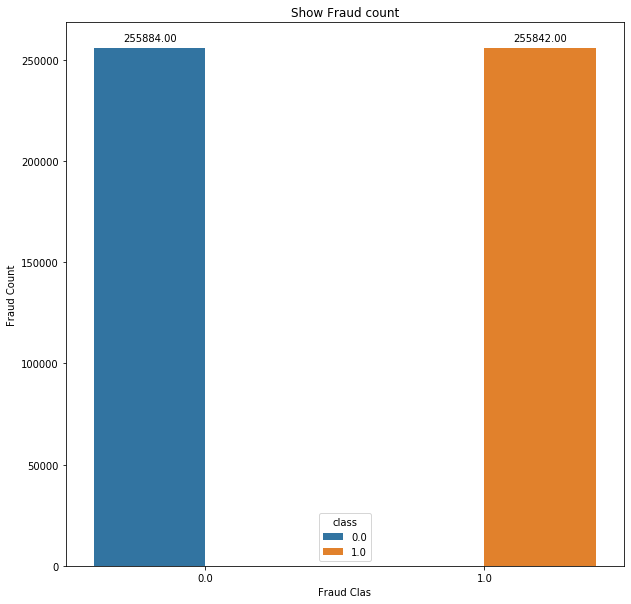

In [14]:
plt.figure(figsize=(10, 10))
splot = sns.countplot('class', data=frame_oversampled, hue="class")
plt.title('Show Fraud count')
plt.xlabel('Fraud Clas')
plt.ylabel('Fraud Count')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


Now let see the impact of the oversampling on correlation Matrix. So we will plot correlation Matrix before and after the over-sampling.

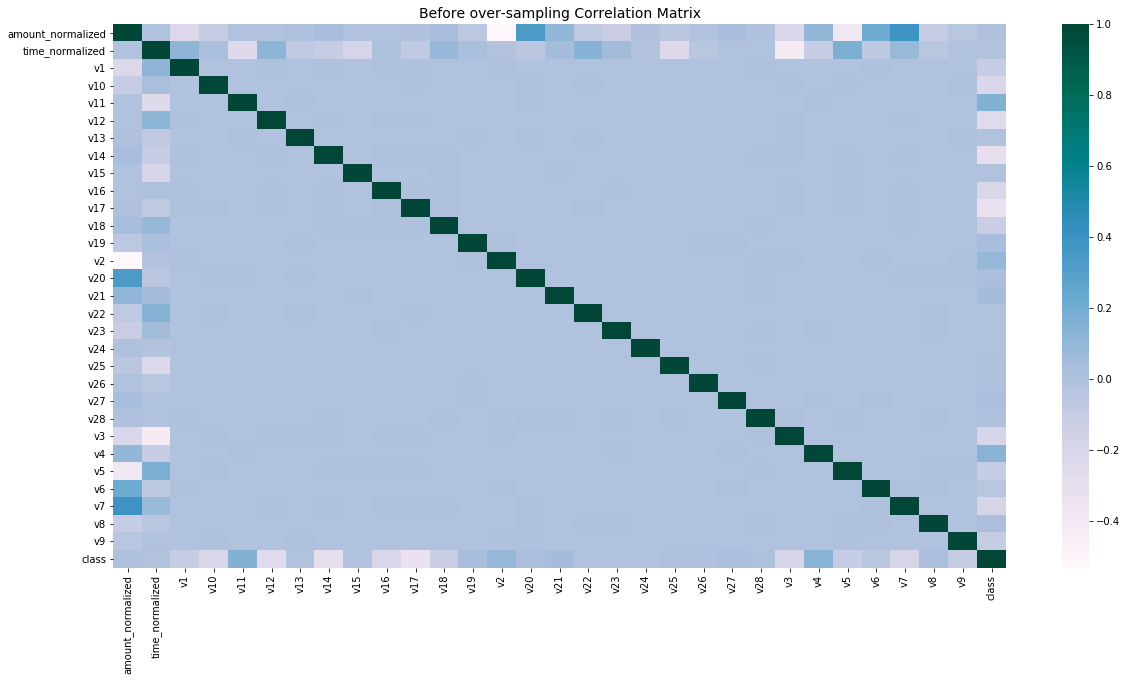

In [15]:
fig, ax = plt.subplots(figsize=(20,10))         


Correlation = frame.corr()
sns.heatmap(Correlation, cmap='PuBuGn', annot_kws={'size':30}, ax=ax)
ax.set_title("Before over-sampling Correlation Matrix", fontsize=14)

plt.show()

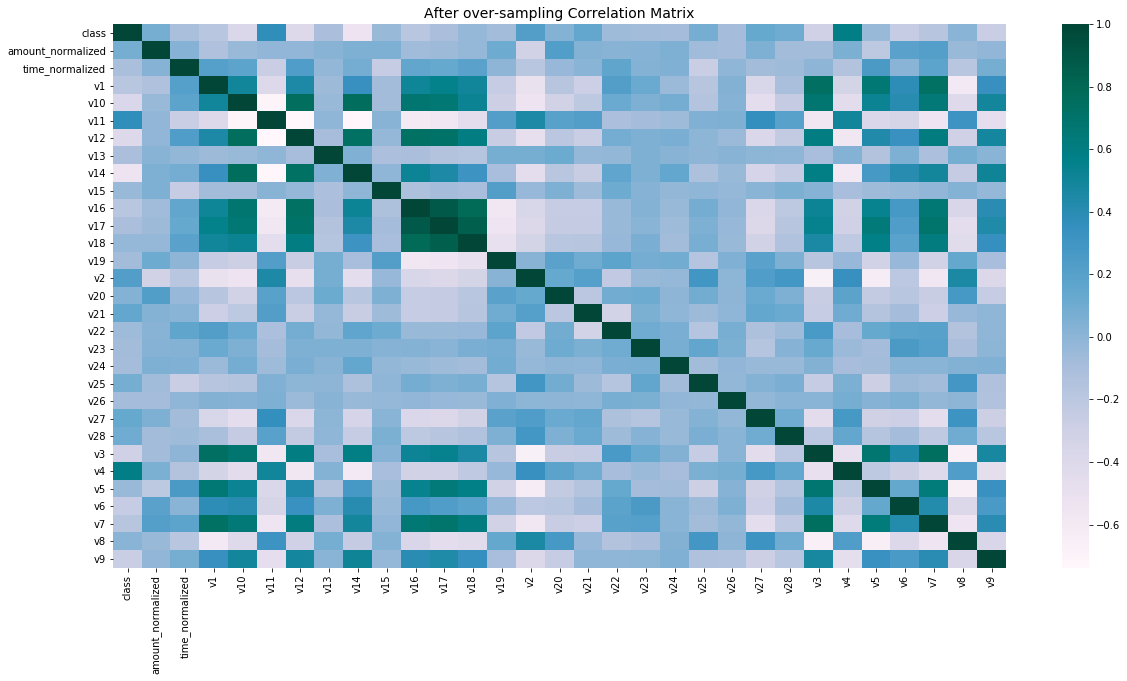

In [16]:
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = frame_oversampled.corr()
sns.heatmap(corr, cmap='PuBuGn', annot_kws={'size':30}, ax=ax)
ax.set_title("After over-sampling Correlation Matrix", fontsize=14)

plt.show()

A good practise that you shuffle the dataset before splitting it. When you shuffle your dataset before the training , you are reduce the probability of the model bias.




In [17]:
frame_shuffled = frame_oversampled.sample(frac=1)
frame_shuffled.head()

,class,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,...,v26,v27,v28,v3,v4,v5,v6,v7,v8,v9
179268,0.0,-0.346072,-1.074286,1.202209,0.134037,1.484538,0.560672,-0.867229,0.659474,0.432949,...,0.068024,-0.039548,0.008633,0.597454,0.563401,-0.616978,-0.810417,-0.108705,-0.011281,-0.067876
407294,1.0,0.176150,0.616425,-2.736199,-4.622509,3.995315,-4.474886,0.784922,-7.082681,-0.269554,...,0.075760,0.008206,0.054532,-3.673483,1.178470,-1.209257,-1.261332,-1.948152,0.370094,-1.765596
247376,0.0,-0.321964,1.026680,2.049203,-0.224324,0.562039,1.010019,0.903148,-1.074355,-1.084105,...,-0.489311,0.001187,-0.038770,-2.645752,1.149306,1.587711,-0.111942,0.626302,-0.194642,-0.244879
300014,1.0,-0.351136,-0.908599,0.900502,-1.975099,3.344270,-1.575793,-1.206463,-7.087714,0.004329,...,0.459278,0.072376,0.214530,-3.817620,4.541598,3.127343,-1.347989,1.540684,-0.381843,-2.702956
271803,1.0,0.363105,-1.683056,-2.093179,-1.894114,2.414190,-5.828372,-0.276559,-2.409783,-0.582169,...,-0.549393,0.151829,-0.126207,-0.580918,2.043289,-0.699979,-0.391610,0.030710,-0.455553,-0.486144


Split your dataset to traing_dataset  which represent %80 of the whole dataset. And  %20 for validation_datset which will be used for model evulations during the training process. 



Reference https://github.com/awsdocs/amazon-sagemaker-developer-guide/blob/master/doc_source/automatic-model-tuning-ex-data.md


In [18]:
train_dataset, validation_dataset = np.split(frame_shuffled, [int(0.8 * len(frame_shuffled))])
train_dataset.to_csv('./train.csv', header=False, index=False)
validation_dataset.to_csv('./validation.csv', header=False, index=False)

In [19]:
print("Total number of rows in shuffled_dataset is :- " + str(frame_shuffled.time_normalized.count()))
print("Total number of rows in training_dataset is :- " + str(train_dataset.time_normalized.count()))
print("Total number of rows in validation_dataset is :- " + str(validation_dataset.time_normalized.count()))
print("Total number of rows in test_dataset is :- " + str(test_dataset.time_normalized.count()))

Total number of rows in shuffled_dataset is :- 511726
Total number of rows in training_dataset is :- 409380
Total number of rows in validation_dataset is :- 102346
Total number of rows in test_dataset is :- 28481


In [20]:
Prefix_dataset="dataset"
boto3.Session().resource('s3').Bucket(Bucket_name).Object(os.path.join(Prefix_dataset, 'train_dataset/train.csv')).upload_file('./train.csv')
boto3.Session().resource('s3').Bucket(Bucket_name).Object(os.path.join(Prefix_dataset, 'validation_dataset/validation.csv')).upload_file('./validation.csv')

### Model training stage using the XGBoost algorithm

XGBoost is stands for eXtreme Gradient Boosting, and was introuduce in 2016 by two reseacher at the University of Washington Tianqi Chen and Carlos Guestrin https://arxiv.org/pdf/1603.02754.pdf
XGBoost is based on an implementation of gradient boosted decision trees designed. And credited winning many Kaggle competitions as it's fast compared to other implementations of gradient boosting algorithms with better performance.
XGBoost usecase can be regression, classification, ranking,forecasting.. etc.
To get started with XGBoost on Sagemaker please refer to https://github.com/aws/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone
 and
 https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb



In [21]:
# output_bucket_path is S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
#load xgboost container image from Sagemaker built-in algorithms
output_prefix = "sagemaker/SAP-FraudDetection"
output_bucket_path = f"s3://{Bucket_name}"
from sagemaker.amazon.amazon_estimator import get_image_uri
xgboost_container = sagemaker.image_uris.retrieve('xgboost', region, 'latest')


In [22]:
# define the data type and paths to the training and validation datasets
content_type = "csv"
train_input = sagemaker.TrainingInput("s3://{}/{}/{}/".format(Bucket_name, Prefix_dataset, 'train_dataset'), content_type=content_type)
validation_input = sagemaker.TrainingInput("s3://{}/{}/{}/".format(Bucket_name, Prefix_dataset, 'validation_dataset'), content_type=content_type)




In [23]:
#reference :https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
import sagemaker
import boto3
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.8",
        "objective":"binary:logistic",
        "num_round":"100"}

# set an output path where the trained model will be saved

output_prefix = "sagemaker/SAP-FraudDetection"
output_bucket_path = f"s3://{Bucket_name}"


# construct a SageMaker estimator that calls the xgboost-container


estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, 
                                          output_path='s3://{}/{}/output'.format(Bucket_name, output_prefix))



# execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

2020-12-28 23:01:49 Starting - Starting the training job...
2020-12-28 23:02:16 Starting - Launching requested ML instancesProfilerReport-1609196509: InProgress
......
2020-12-28 23:03:17 Starting - Preparing the instances for training...
2020-12-28 23:03:44 Downloading - Downloading input data...
2020-12-28 23:04:18 Training - Downloading the training image.Arguments: train
[2020-12-28:23:04:21:INFO] Running standalone xgboost training.
[2020-12-28:23:04:21:INFO] File size need to be processed in the node: 253.76mb. Available memory size in the node: 23831.02mb
[2020-12-28:23:04:21:INFO] Determined delimiter of CSV input is ','
[23:04:21] S3DistributionType set as FullyReplicated
[23:04:21] 409380x30 matrix with 12281400 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-12-28:23:04:21:INFO] Determined delimiter of CSV input is ','
[23:04:21] S3DistributionType set as FullyReplicated
[23:04:22] 102346x30 matrix with 3070380 entries loaded from /op

### Model deployment
Now let's deploy the model on a hosted endpoint so we can inference the trained model

In [24]:
from sagemaker.serializers import CSVSerializer

xgb_predictor_fraud = estimator.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m4.xlarge',
    serializer=CSVSerializer())

---------------!

### Model Evaluation
Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request. But first, we'll need to setup serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.

Now, we'll use a simple function to:

1. Loop over our test dataset
2. Split it into mini-batches of rows
3. Convert those mini-batchs to CSV string payloads
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output our model provides into a NumPy array

reference https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb


In [25]:
import numpy as np
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor_fraud.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_dataset.values[:, 1:])

There are many ways to compare the performance of a machine learning model like
1. Module Accuracy
2. simple confusion matrix.


In [26]:
from sklearn.metrics import accuracy_score
predictions[:10]
predictions_round = [round(value) for value in predictions]
predictions_round[:10]
# evaluate predictions
accuracy = accuracy_score(test_dataset['class'], predictions_round)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.68%


In [27]:
pd.crosstab(index=test_dataset.iloc[:, 30], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0.0,27252,1179
1.0,50,0


out of 28481 total transactions, we've predicted 0 fraud out of 0 them (true positives) correctly. And, we incorrectly predicted 1179 transactions as fraud which then ended up not being a fraud so (false positives).  There are also 50 was fraud and we didnn't predicted them (false negatives).

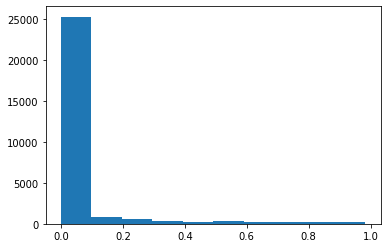

In [28]:
plt.hist(predictions)
plt.show()

As we are using the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5, we can lower the threshold to detect more fraud but this will increase the false positive . As below now we dedicate 44 fraud out of the 33 but got 27053 false positive.

In [29]:
pd.crosstab(index=test_dataset.iloc[:, 30], columns=np.where(predictions > 0.00001, 1, 0))

col_0,0,1
class,,
0.0,1378,27053
1.0,17,33


In [30]:
test_dataset_prediction = test_dataset
test_dataset_prediction['prediction'] =predictions
test_dataset_prediction.head()

,amount_normalized,time_normalized,v1,v10,v11,v12,v13,v14,v15,v16,...,v28,v3,v4,v5,v6,v7,v8,v9,class,prediction
89863,-0.063368,-0.677703,-2.286589,-0.796739,-0.789738,0.278244,0.127620,0.665553,0.314590,0.371640,...,-0.353838,0.675376,0.775268,1.238723,-2.016757,-0.239207,0.373672,-0.545885,0.0,0.000031
251734,-0.237284,0.644353,-0.208630,0.232557,0.219473,-0.816806,-1.145790,-0.274802,-1.022856,1.688476,...,-0.001663,0.934727,-2.244473,-0.378517,-0.353930,-0.337660,0.257838,-0.487426,0.0,0.294019
163250,-0.313288,0.862176,1.910769,-0.127525,-0.416776,0.070996,-1.375941,0.121199,0.554890,-0.125142,...,-0.030055,0.119820,0.755154,-1.381563,-1.164313,-0.669017,-0.046491,1.610354,0.0,0.000577
17985,-0.144049,1.039905,2.163458,1.669506,-0.059160,-0.810734,-0.331276,-0.514041,-0.103042,0.422925,...,-0.034644,-0.325827,-1.780584,-1.578082,0.652957,-2.015717,0.336696,-0.696090,0.0,0.001141
220817,-0.350190,1.591558,2.102351,-0.828395,0.987913,-0.674080,-1.846386,-1.929413,-0.483131,0.754312,...,-0.031846,-3.428702,0.494589,1.414167,-1.065919,0.601198,-0.213220,0.047607,0.0,0.019513


In [31]:
test_dataset_prediction.to_csv('./test_dataset_prediction.csv', header=True, index=True)
boto3.Session().resource('s3').Bucket(Bucket_name).Object(os.path.join("Sagemaker_output", 'test_dataset_prediction/test_dataset_prediction.csv')).upload_file('./test_dataset_prediction.csv')